## Import libraries

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import shutil
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
#from sklearn.model_selection import train_test_split

## Generate image dataset

In [2]:
train_ds, val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset/ALL/Training",
    validation_split = 0.2,
    subset = "both",
    seed = 1337,
    image_size = (180, 180),
    batch_size = 128,
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset/ALL/Testing",
    image_size = (180, 180),
    batch_size = 128,
    shuffle = False
)

class_names = os.listdir("dataset/ALL/Training")

Found 8000 files belonging to 4 classes.
Using 6400 files for training.
Using 1600 files for validation.
Found 2000 files belonging to 4 classes.


## Visualize the data

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## Standardize the data

In [ ]:
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

## Build the model 

In [12]:
num_classes = len(class_names)

model = Sequential([
    layers.Rescaling(1./255, input_shape=(180, 180, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

## Compile the model

In [13]:
model.compile(optimizer='adam', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']
             )

## Model Summary

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 16)        2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 16)        2

## Train the model

In [15]:
cnn_model = model.fit(train_ds, validation_data = val_ds, epochs = 10)

Epoch 1/10
100/100 [==============================] - 1673s 16s/step - loss: 0.7730 - accuracy: 0.6768 - val_loss: 0.4718 - val_accuracy: 0.8122
Epoch 2/10
100/100 [==============================] - ETA: 0s - loss: 0.3984 - accuracy: 0.8414 

KeyboardInterrupt: 

## Save the model

In [ ]:
model.save("models/brain_tumor_model.h5")

## Load the model

In [4]:
model = load_model("models/ALL_model.h5")

## Predict on new data

In [5]:
#image_url = "dataset/Brain Cancer/Testing/brain_menin/brain_menin_2514.jpg"

#img = tf.keras.utils.load_img(
#    image_url, target_size = (180, 180)
#)

#img_array = tf.keras.utils.img_to_array(img)
#img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(test_ds)
score = tf.nn.softmax(predictions[0])
print(len(predictions))
print("This image is most likely a {} with a {:.2f} percent confidence"
      .format(class_names[np.argmax(score)], 100 * np.max(score))
     )
predictions


16/16 [==============================] - 49s 3s/step
2000
This image is most likely a all_benign with a 98.10 percent confidence


array([[ 1.30407629e+01,  9.09895706e+00,  7.32410192e-01,
        -1.12727785e+01],
       [ 1.54708052e+01,  3.47297549e+00,  1.39900768e+00,
        -5.19773054e+00],
       [ 1.10040417e+01,  8.64656544e+00,  4.58759928e+00,
        -2.68777599e+01],
       ...,
       [ 1.82379842e-01,  1.42299756e-01, -1.69157848e-01,
         7.75468969e+00],
       [-6.52633607e-05, -9.36502755e-01,  6.02763534e-01,
         6.97600174e+00],
       [-4.07529593e-01, -7.61804342e-01, -8.52100968e-01,
         1.09879389e+01]], dtype=float32)

## Get all predictions in an array

In [6]:
#Get the results in an array
y_predict = []
for i in range(len(predictions)):
    score = tf.nn.softmax(predictions[i])
    class_name = [np.argmax(score)]
    y_predict.append(class_name)

## Get actual class names

In [9]:
dataset_path = "dataset/ALL/Testing/"

y_test = []
for i in range(len(class_names)):
    classes = os.listdir(dataset_path+class_names[i])
    for j in range(len(classes)):
        y_test.append(i)

print(len(y_test))

2000


## Evaluate performance metrics

In [10]:
#print(classification_report(y_test, y_predict, target_names=class_names))
accuracy = metrics.accuracy_score(y_test, y_predict)
precision = metrics.precision_score(y_test, y_predict, average = "macro")
recall = metrics.recall_score(y_test, y_predict, average = "macro")
f1_score = metrics.f1_score(y_test, y_predict, average = "macro")

print("Accuracy = " + str(accuracy))
print("Precision = " + str(precision))
print("Recall = " + str(recall))
print("F1 score = " + str(f1_score))

Accuracy = 0.9535
Precision = 0.9545759118989345
Recall = 0.9534999999999999
F1 score = 0.9534949617894453


## Confusion matrix

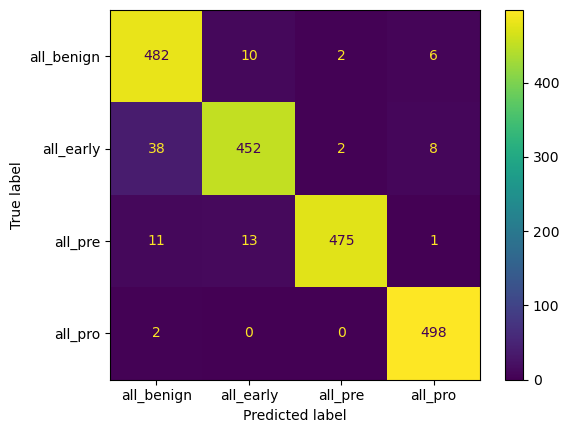

In [11]:
confusion_matrix = metrics.confusion_matrix(y_test, y_predict)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = class_names)
cm_display.plot()
plt.show()